In [1]:
import pandas as pd
try:
  import pickle5 as pickle
except:
  !pip install pickle5
  import pickle5 as pickle
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding,  Concatenate, Lambda
from keras.models import Model
from sklearn.metrics import roc_auc_score,roc_curve, auc
from numpy import random
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import seaborn as sns

import sys
sys.path.insert(0,'/content/drive/MyDrive/ML_Data/')
import functions as f

     |████████████████████████████████| 133kB 5.5MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219268 sha256=dff11daca8132e751de4d347cd3889fe8fc0a460a0ee65dec716916ac2c1769c
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [2]:
def load_data(D=1,randomize=False):
    try:
        with open('/content/drive/MyDrive/ML_Data/df_train_'+str(D)+'D.pickle', 'rb') as handle:
            df_train = pickle.load(handle)
    except:
        df_train = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-train.pkl")
    try:
        with open('/content/drive/MyDrive/ML_Data/df_test_'+str(D)+'D.pickle', 'rb') as handle:
            df_test = pickle.load(handle)
    except:
        df_test = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-independent.pkl")
    if randomize:
        return shuff_together(df_train,df_test)
    else:
        return df_train,df_test

df_train,df_test = load_data(2)
print('The data used will be:')
df_train[['Human','Yersinia']]

The data used will be:


,Human,Yersinia
0,"[MK, KD, DK, KQ, QK, KK, KK, KK, KE, ER, RT, T...","[MA, AK, KA, AS, SR, RH, HN, NL, LS, SI, IG, G..."
1,"[MS, SW, WS, SG, GL, LL, LH, HG, GL, LN, NT, T...","[MQ, QH, HV, VT, TG, GS, SK, KR, RR, RL, LI, I..."
2,"[MS, SL, LF, FD, DL, LF, FR, RG, GF, FF, FG, G...","[MA, AE, EL, LP, PA, AK, KR, RR, RF, FT, TR, R..."
3,"[MA, AV, VA, AP, PR, RL, LF, FG, GG, GL, LC, C...","[MR, RI, IF, FA, AI, IS, SC, CS, SS, SY, YT, T..."
4,"[MS, ST, TI, IQ, QS, SE, ET, TD, DC, CY, YD, D...","[MS, SY, YA, AF, FP, PG, GT, TF, FP, PG, GR, R..."
...,...,...
6265,"[MS, SY, YF, FG, GE, EH, HF, FW, WG, GE, EK, K...","[MI, IT, TT, TD, DG, GN, NS, SA, AV, VA, AS, S..."
6266,"[MT, TV, VG, GK, KS, SS, SK, KM, ML, LQ, QH, H...","[MS, SQ, QP, PP, PF, FW, WQ, QQ, QK, KT, TL, L..."
6267,"[MN, NN, NL, LS, SF, FS, SE, EL, LC, CC, CL, L...","[MS, SE, ED, DR, RH, HQ, QQ, QR, RQ, QQ, QR, R..."
6268,"[MA, AP, PE, EI, IN, NL, LP, PG, GP, PM, MS, S...","[MK, KN, NL, LS, SF, FV, VA, AG, GL, LV, VI, I..."


Median length of Human sequence is 478


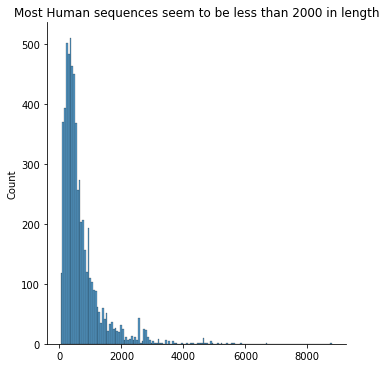

In [ ]:
lengths = sorted(len(s) for s in df_train['Human'])
print("Median length of Human sequence is",lengths[len(lengths)//2])
_  = sns.displot(lengths)
_=plt.title("Most Human sequences seem to be less than 2000 in length")

Median length of Yersinia sequence is 335


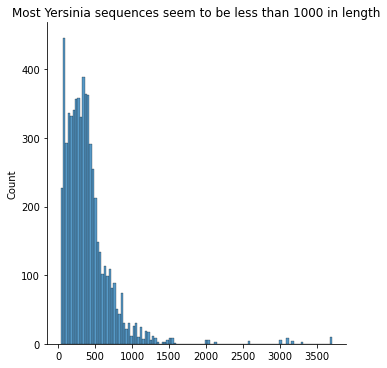

In [ ]:
lengths = sorted(len(s) for s in df_train['Yersinia'])
print("Median length of Yersinia sequence is",lengths[len(lengths)//2])
_  = sns.displot(lengths)
_=plt.title("Most Yersinia sequences seem to be less than 1000 in length")

MAX_VOCAB_SIZE is 1000
MAX_SEQUENCE_LENGTH is 1000
max sequences1_train length: 8796
min sequences1_train length: 40
median sequences1_train length: 478


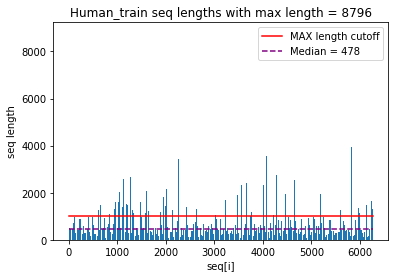

max word index sequences1_train: 400
max sequences2_train length: 3709
min sequences2_train length: 34
median sequences2_train length: 335


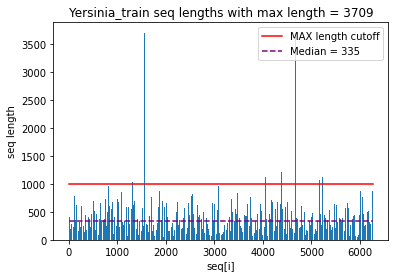

max word index sequences2_train: 400
Found 400 unique tokens in tokenizer1.
Found 400 unique tokens in tokenizer2.
Center padding
Shape of data1 tensor: (6270, 1000)
Shape of data2 tensor: (6270, 1000)
max test_sequences1 length: 5634
min test_sequences1 length: 38
median test_sequences1 length: 495


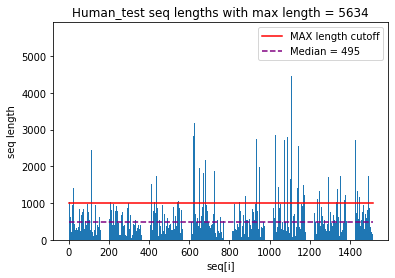

max test_sequences2 length: 3709
min test_sequences2 length: 34
median test_sequences2 length: 330


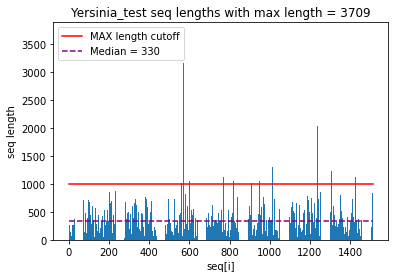

Center padding for test seq.
Shape of test_data1 tensor: (1514, 1000)
Shape of test_data2 tensor: (1514, 1000)
num_words is 401


In [3]:
data1_2D_doubleip,data2_2D_doubleip,data1_test_2D_doubleip,data2_test_2D_doubleip,num_words_2D,MAX_SEQUENCE_LENGTH_2D,MAX_VOCAB_SIZE_2D = f.get_seq_data_doubleip(1000,1000,df_train,df_test,show=True)

In [ ]:
EMBEDDING_DIM_2D = 5 #OR 10?
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 20
M_2D=15

embedding_matrix_2D = random.uniform(-1, 1,(num_words_2D,EMBEDDING_DIM_2D))

embedding_layer1_2D = Embedding(
  num_words_2D,
  EMBEDDING_DIM_2D,
  weights=[embedding_matrix_2D],
  input_length=MAX_SEQUENCE_LENGTH_2D,
  trainable=True
)
embedding_layer2_2D = Embedding(
  num_words_2D,
  EMBEDDING_DIM_2D,
  weights=[embedding_matrix_2D],
  input_length=MAX_SEQUENCE_LENGTH_2D,
  trainable=True
)

In [ ]:
inputA = Input(shape=(MAX_SEQUENCE_LENGTH_2D,),name="Human_2D_doubleip")
x1 = embedding_layer1_2D(inputA)
x1 = Bidirectional(LSTM(M_2D, return_sequences=True),name="Human_Bidirectional_2D_doubleip")(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(128, activation='relu')(x1)
#x1 = Dropout(0.2)(x1)
x1 = GlobalMaxPool1D()(x1)
x1_2D_doubleip = Model(inputs=inputA, outputs=x1)

inputB = Input(shape=(MAX_SEQUENCE_LENGTH_2D,),name="Yersinia_2D_doubleip")
x2 = embedding_layer2_2D(inputB)
x2 = Bidirectional(LSTM(M_2D, return_sequences=True),name="Yersinia_Bidirectional_2D_doubleip")(x2)
x2 = Dropout(0.2)(x2)
x2 = Dense(128, activation='relu')(x2)
#x2 = Dropout(0.2)(x2)
x2 = GlobalMaxPool1D()(x2)
x2_2D_doubleip = Model(inputs=inputB, outputs=x2)

concatenator = Concatenate(axis=1)
x = concatenator([x1_2D_doubleip.output, x2_2D_doubleip.output]) # output is N x 4M
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid",name="Final")(x)

model2D_doubleip = Model(inputs=[x1_2D_doubleip.input, x2_2D_doubleip.input], outputs=output)


model2D_doubleip.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)


#model.summary()

print('Training model...')
jk = model2D_doubleip.fit(
  [data1_2D_doubleip,data2_2D_doubleip],
  df_train['label'].values,
  batch_size=128,
  epochs=EPOCHS,
  #validation_split=VALIDATION_SPLIT,
  verbose=1
)

#print(roc_auc_score(df_train['label'].values, model.predict([da,data2])))

Training model...
Epoch 1/20
49/49 [==============================] - 32s 198ms/step - loss: 0.7451 - accuracy: 0.5160
Epoch 2/20
49/49 [==============================] - 10s 202ms/step - loss: 0.6239 - accuracy: 0.6439
Epoch 3/20
49/49 [==============================] - 10s 202ms/step - loss: 0.5584 - accuracy: 0.7132
Epoch 4/20
49/49 [==============================] - 10s 203ms/step - loss: 0.4937 - accuracy: 0.7540
Epoch 5/20
49/49 [==============================] - 10s 205ms/step - loss: 0.4588 - accuracy: 0.7779
Epoch 6/20
49/49 [==============================] - 10s 206ms/step - loss: 0.4534 - accuracy: 0.7842
Epoch 7/20
49/49 [==============================] - 10s 204ms/step - loss: 0.4167 - accuracy: 0.8000
Epoch 8/20
49/49 [==============================] - 10s 205ms/step - loss: 0.3737 - accuracy: 0.8271
Epoch 9/20
49/49 [==============================] - 10s 205ms/step - loss: 0.3826 - accuracy: 0.8210
Epoch 10/20
49/49 [==============================] - 10s 205ms/step - los

In [ ]:
yhat =  model2D_doubleip.predict([data1_test_2D_doubleip,data2_test_2D_doubleip])
y = df_test['label'].values
from sklearn import metrics
fpr, tpr, thresholds = roc_curve(y, yhat)
auc = metrics.auc(fpr, tpr)
auc

0.8352304951234537